In [44]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt

In [45]:
df = pd.read_csv('data/data_by_month/jan_2023.csv')
ids = pd.read_csv('data/data_by_month/airline_id.csv')

In [46]:
# data cleaning
df.fillna(0, inplace=True)

# rename airlines
airline_names = pd.DataFrame(df['OP_CARRIER_AIRLINE_ID'].unique(), columns=['Code']).merge(ids, on='Code', how='left')
airline_names['Description'] = airline_names['Description'].apply(lambda x: x.split(':')[0])
airline_names['Description'] = airline_names['Description'].apply(lambda x: x.split('LLC')[0])

airline_names


,Code,Description
0,19393,Southwest Airlines Co.
1,19687,Horizon Air
2,19690,Hawaiian Airlines Inc.
3,19790,Delta Air Lines Inc.
4,19805,American Airlines Inc.
5,19930,Alaska Airlines Inc.
6,19977,United Air Lines Inc.
7,20046,Air Wisconsin Airlines Corp
8,20304,SkyWest Airlines Inc.
9,20363,Endeavor Air Inc.


In [54]:
delay_fields = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
grouped_df = df.groupby('OP_CARRIER_AIRLINE_ID')[delay_fields].sum()
grouped_df['TOTAL_FLIGHTS'] = df.groupby('OP_CARRIER_AIRLINE_ID').size()
grouped_with_airline = pd.merge(grouped_df, airline_names, left_on='OP_CARRIER_AIRLINE_ID', right_on='Code')
average_delays = grouped_with_airline
for delay in delay_fields:
    average_delays[delay] = grouped_with_airline[delay] / grouped_with_airline['TOTAL_FLIGHTS']
df

,MONTH,OP_CARRIER_AIRLINE_ID,ORIGIN_AIRPORT_ID,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,DEST_AIRPORT_ID,DEST_STATE_ABR,DEST_STATE_NM,DEP_DELAY,TAXI_OUT,ARR_DELAY,CANCELLED,DIVERTED,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,19393,10140,NM,New Mexico,10423,TX,Texas,0.0,0.0,0.0,1.0,0.0,0.0,619.0,0.0,0.0,0.0,0.0,0.0
1,1,19393,10140,NM,New Mexico,10423,TX,Texas,0.0,0.0,0.0,1.0,0.0,0.0,619.0,0.0,0.0,0.0,0.0,0.0
2,1,19393,10140,NM,New Mexico,10423,TX,Texas,-10.0,9.0,-14.0,0.0,0.0,77.0,619.0,0.0,0.0,0.0,0.0,0.0
3,1,19393,10140,NM,New Mexico,10423,TX,Texas,-9.0,11.0,-2.0,0.0,0.0,76.0,619.0,0.0,0.0,0.0,0.0,0.0
4,1,19393,10140,NM,New Mexico,10423,TX,Texas,-8.0,11.0,-20.0,0.0,0.0,80.0,619.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
573872,1,20500,15919,AR,Arkansas,13930,IL,Illinois,150.0,23.0,130.0,0.0,0.0,70.0,522.0,130.0,0.0,0.0,0.0,0.0
573873,1,20500,15919,AR,Arkansas,13930,IL,Illinois,214.0,49.0,221.0,0.0,0.0,68.0,522.0,0.0,0.0,7.0,0.0,214.0
573874,1,20500,15919,AR,Arkansas,13930,IL,Illinois,317.0,16.0,290.0,0.0,0.0,71.0,522.0,0.0,0.0,290.0,0.0,0.0
573875,1,20500,15919,AR,Arkansas,13930,IL,Illinois,377.0,48.0,389.0,0.0,0.0,79.0,522.0,0.0,4.0,12.0,0.0,373.0


Look at averages

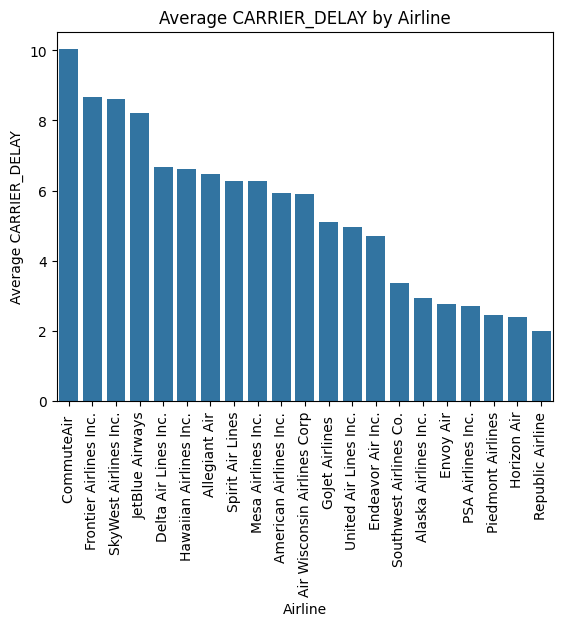

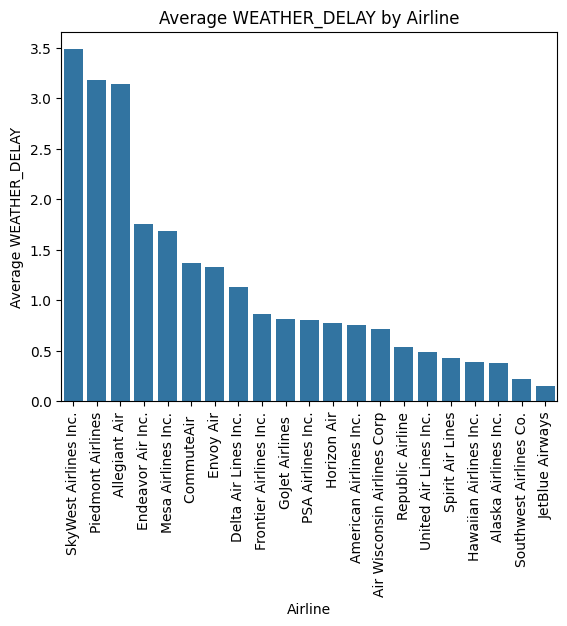

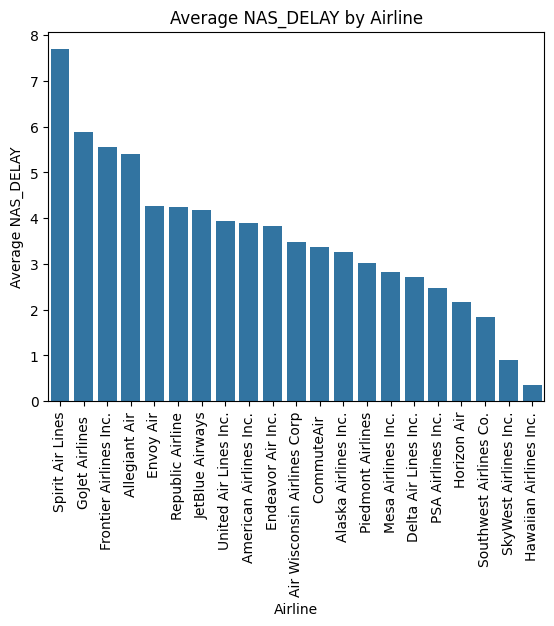

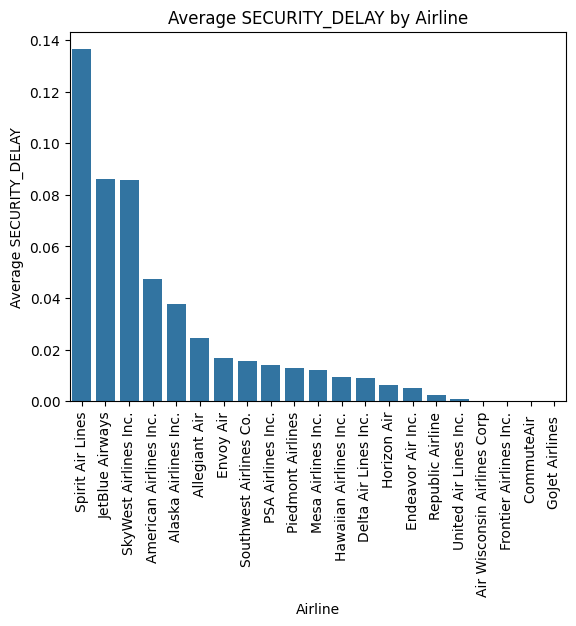

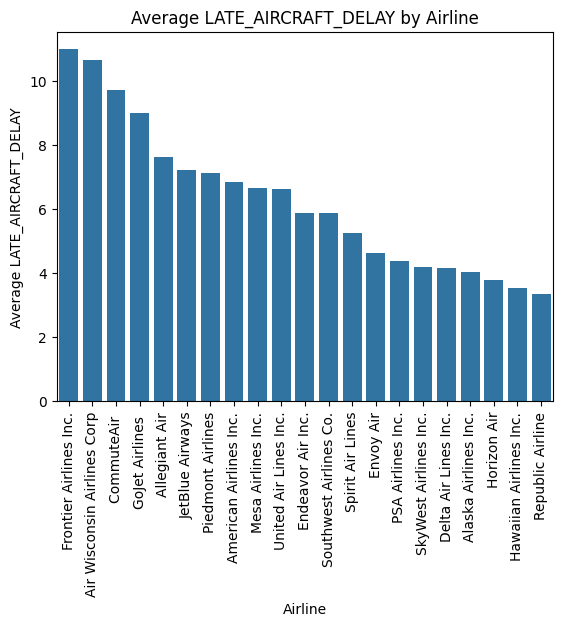

In [50]:
for delay in delay_fields:
    average_delays_sorted = average_delays.sort_values(f'{delay}', ascending=False)
    plt.figure()
    plt.title(f'Average {delay} by Airline')
    plt.xlabel('Airline')
    plt.ylabel(f'Average {delay}')
    plt.xticks(rotation=90)
    sns.barplot(x='Description', y=f'{delay}', data=average_delays_sorted)





Look at cancellations